TESTED FEATURES: 
Index(['vel5', 'vel10', 'vel15', 'vel30', 'vel60', 'acc5', 'acc10', 'acc15',
       'acc30', 'acc60', 'stoch12', 'stochDiff6012', 'RSIhl_diff',
       'RSIhl_diffROC', 'HLdiff', 'HL2', 'H2L', 'HLdiff12', 'HLdiff21', 'vol',
       'vol10', 'vol15', 'vol30', 'vol60', 'volD10', 'volD15', 'volD30',
       'volD60', 'vpm5', 'vpm10', 'vpm15', 'vpm30', 'vpm60', 'ToD', 'DoW',
       'mo'],
      dtype='object')
TESTING FOR: 
r30
X shape == (6830, 10, 36).
y shape == (6830,).
0.01042251031828126
1.555336881662674
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


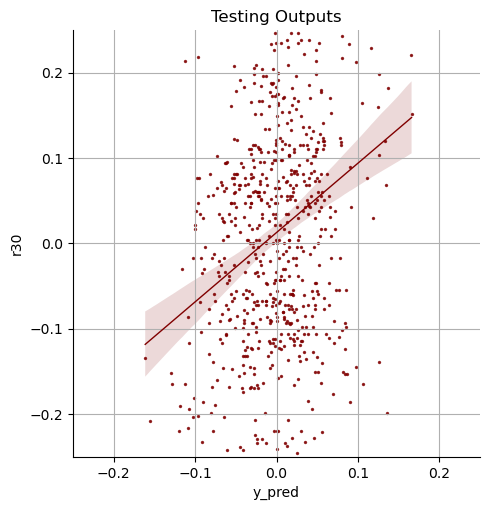

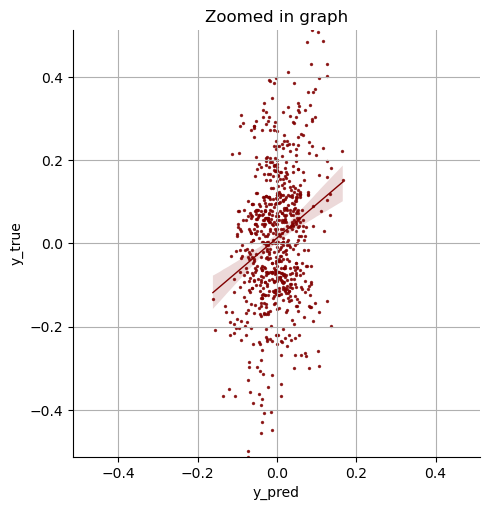

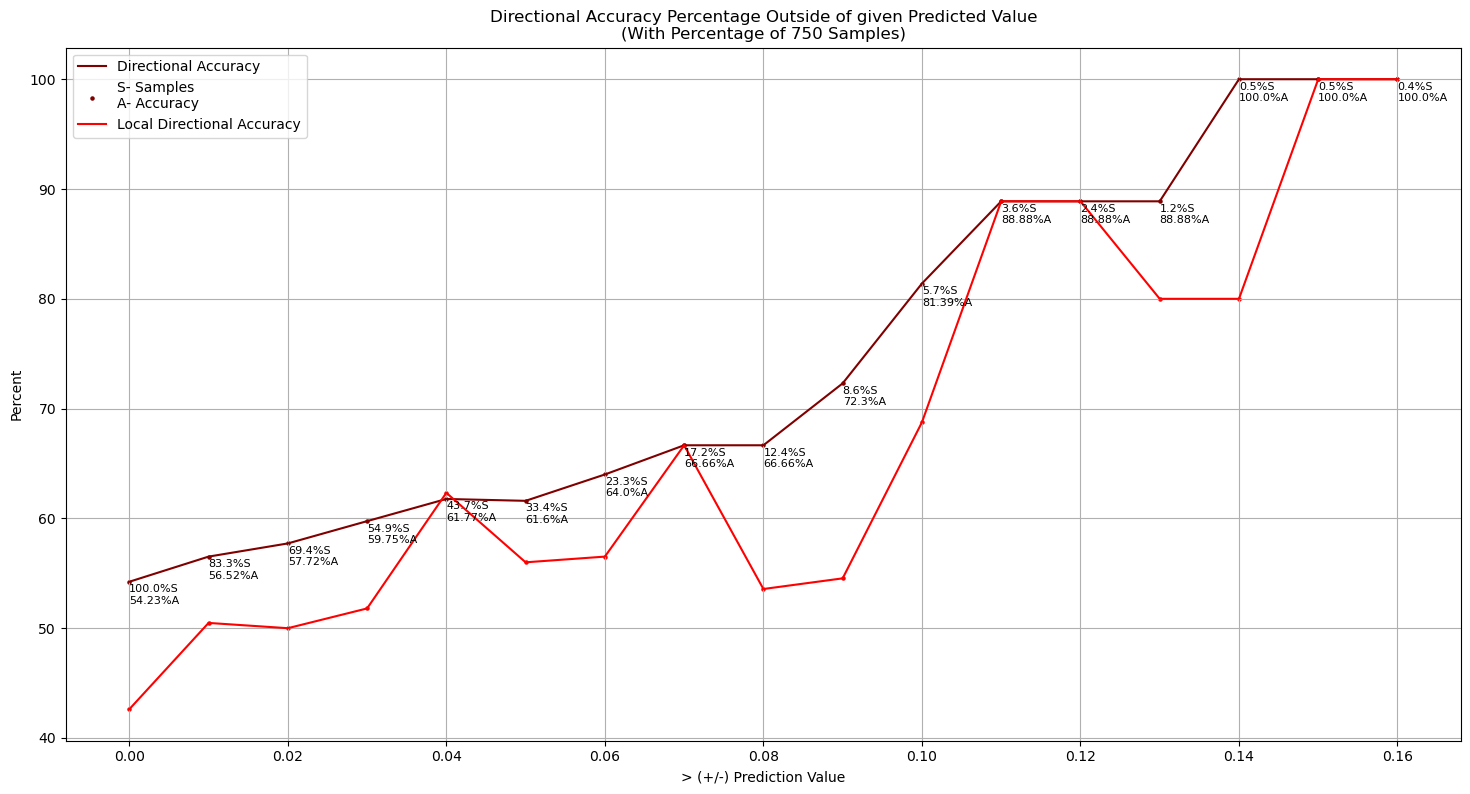

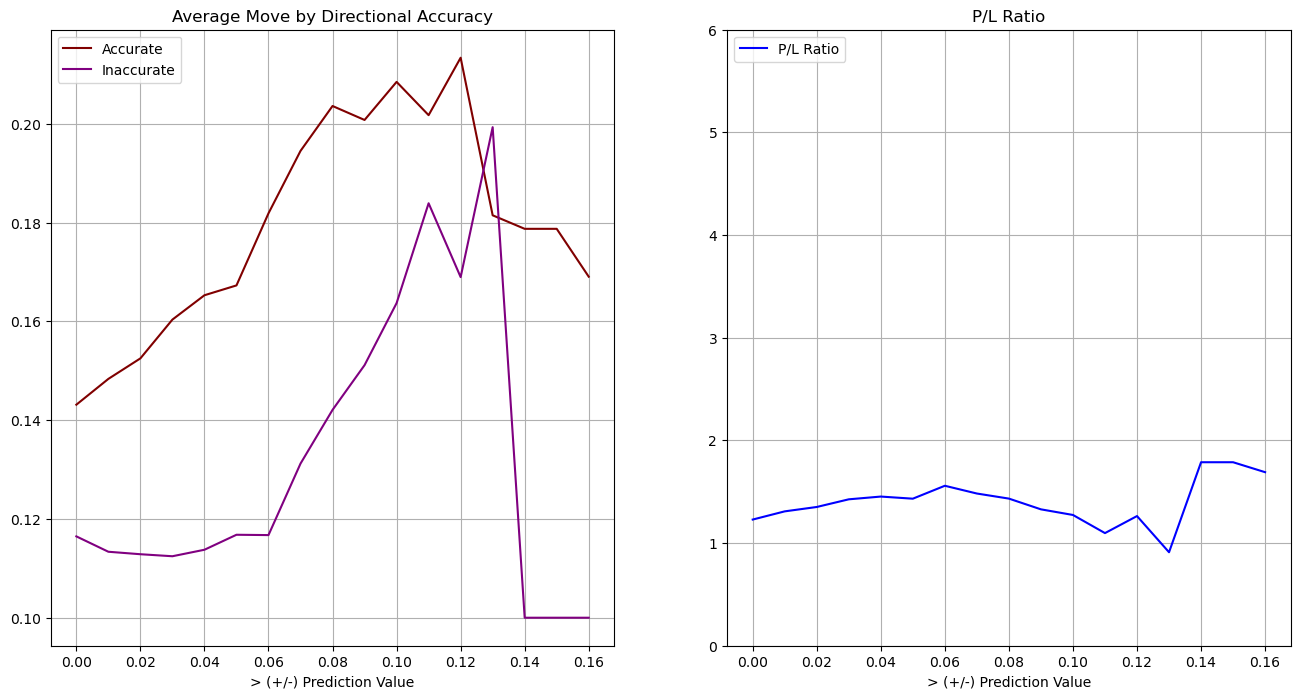

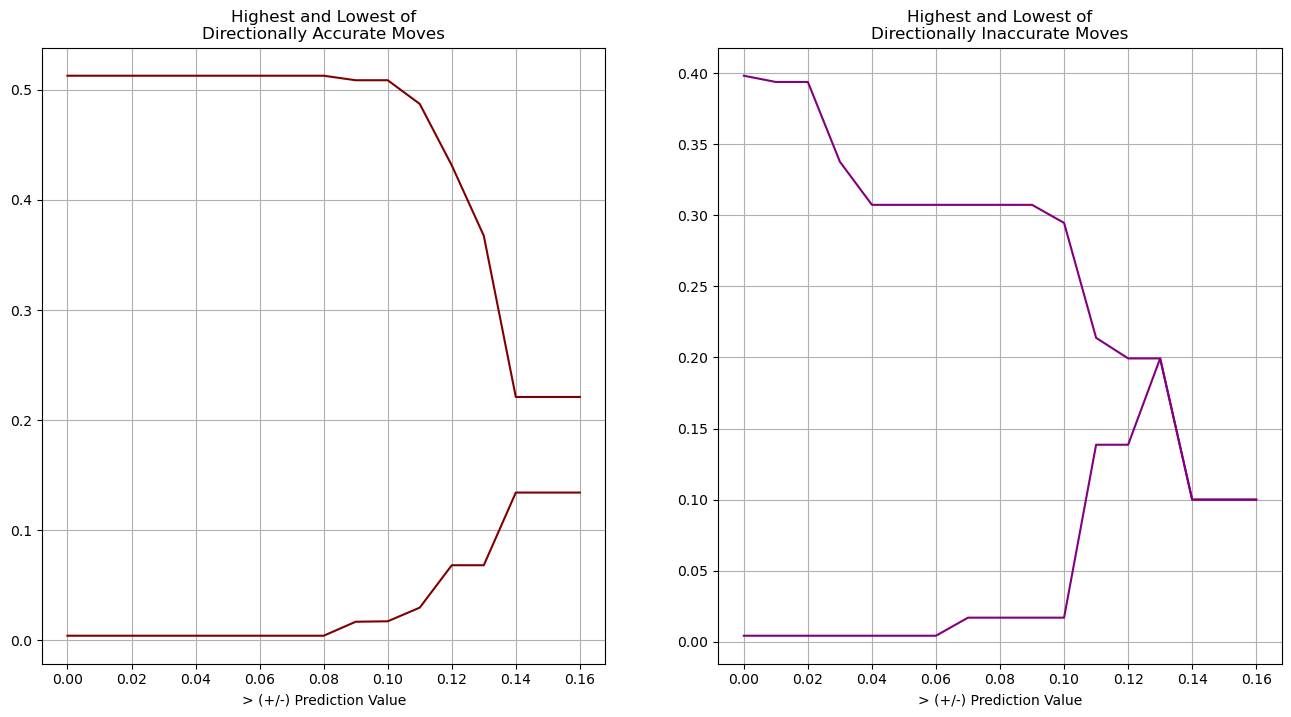

In [31]:
#JJ McCauley + LOGAN KELSCH 
#TEST NN 1

#IMPORT LIBRARIES-------------------------------------------------------

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from keras.optimizers import SGD
from keras.initializers import GlorotUniform
from keras.initializers import RandomNormal
from keras.callbacks import EarlyStopping
from imblearn.over_sampling import SMOTE

#hahaha dont turn this on with high epoch or else
#tf.config.experimental.set_memory_growth

#LOAD DATA FROM CSV-------------------------------------------------------

# Load the dataset
data = pd.read_csv('d1_test_.csv')
dataTRAIN = pd.read_csv('catted_1-8.csv')

#      'Dr1' 'Dr3' 'Mr1' 'Mr3' 
testFor = 'r30'
timeSteps = 10
tType = testFor[0]

data = data.drop(columns=['FT'])#,'FT.1'])
dataTRAIN = dataTRAIN.drop(columns=['FT','FT.1'])
#CALENDAR
#--------------------------------------
#SOLUTION------------------------------
match testFor:
    case 'r1':
        data = data.drop(columns=['r2','r3','r5','r10','r15','r30','r60'])
        dataTRAIN = dataTRAIN.drop(columns=['r2','r3','r5','r10','r15','r30','r60'])
    case 'r2':
        data = data.drop(columns=['r1','r3','r5','r10','r15','r30','r60'])
        dataTRAIN = dataTRAIN.drop(columns=['r1','r3','r5','r10','r15','r30','r60'])
    case 'r3':
        data = data.drop(columns=['r1','r2','r5','r10','r15','r30','r60'])
        dataTRAIN = dataTRAIN.drop(columns=['r1','r2','r5','r10','r15','r30','r60'])
    case 'r5':
        data = data.drop(columns=['r1','r2','r3','r10','r15','r30','r60'])
        dataTRAIN = dataTRAIN.drop(columns=['r1','r2','r3','r10','r15','r30','r60'])
    case 'r10':
        data = data.drop(columns=['r1','r2','r3','r5','r15','r30','r60'])
        dataTRAIN = dataTRAIN.drop(columns=['r1','r2','r3','r5','r15','r30','r60'])
    case 'r15':
        data = data.drop(columns=['r1','r2','r3','r5','r10','r30','r60'])
        dataTRAIN = dataTRAIN.drop(columns=['r1','r2','r3','r5','r10','r30','r60'])
    case 'r30':
        data = data.drop(columns=['r1','r2','r3','r5','r10','r15','r60'])
        dataTRAIN = dataTRAIN.drop(columns=['r1','r2','r3','r5','r10','r15','r60'])
    case 'r60':
        data = data.drop(columns=['r1','r2','r3','r5','r10','r15','r30'])
        dataTRAIN = dataTRAIN.drop(columns=['r1','r2','r3','r5','r10','r15','r30'])


#confirming X and Y features post training
Xfeatures = data.columns[:-1]
Yfeatures = data.columns[-1]
print("TESTED FEATURES: ")
print(Xfeatures)
print("TESTING FOR: ")
print(Yfeatures)

# Separate features and target
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

XTRAIN = dataTRAIN.iloc[:, :-1].values
yTRAIN = dataTRAIN.iloc[:, -1].values

# Standardize the features
scaler1 = StandardScaler()
scaler2 = RobustScaler()
scaler3 = MinMaxScaler(feature_range=(-1,1))

percFit = 0.8
fitSplit = len(X)//(1/(percFit))
negFitSplit = len(X)//(1/(1-percFit))

scaler1.fit(XTRAIN)
XTRAIN = scaler1.transform(XTRAIN)
#scaler2.fit(XTRAIN)
#XTRAIN = scaler2.transform(XTRAIN)
#scaler3.fit(XTRAIN)
#XTRAIN = scaler3.transform(XTRAIN)
X = scaler1.transform(X)
#X = scaler2.transform(X)
#X = scaler3.transform(X)
#scaler3.fit(XTRAIN)


#X = scaler3.transform(X)

#setting data for LSTM
def reformat_to_lstm(X, time_steps=timeSteps):
    X_lstm, y_lstm = [], []
    
    for i in range(time_steps, len(X)):
        # Collect previous time_steps rows for X
        X_lstm.append(X[i-time_steps:i])  
        # The corresponding y value for the last time step in the sequence
    
    X_lstm = np.array(X_lstm)
    
    return X_lstm

X = reformat_to_lstm(X, timeSteps)
y = y[timeSteps:]
y = np.array(y)

XTRAIN = reformat_to_lstm(XTRAIN, timeSteps)
yTRAIN = yTRAIN[timeSteps:]
yTRAIN = np.array(yTRAIN)

print('X shape == {}.'.format(X.shape))
print('y shape == {}.'.format(y.shape))


mos = X[:, timeSteps-1, len(Xfeatures)-1].mean()
print(mos)

def remove_zero_mo_samples(X, y):
    # Get the 'MO' column (index 34 for 0-based indexing) for all time steps and samples
    non_zero_indices = (X[:, timeSteps-1, len(Xfeatures)-1] >= 0)
    # Filter X and y using these indices
    X_filtered = X[non_zero_indices]
    y_filtered = y[non_zero_indices]
    return X_filtered, y_filtered

def remove_extra_filter(X, y):
    indices = (X[:, timeSteps-1, len(Xfeatures)-3] >= -0.321405)#-3 is ToD, this value is 9:30am
    X = X[indices]
    y = y[indices]
    indices = (X[:, timeSteps-1, len(Xfeatures)-3] <= 0.0366699)#-3 is ToD, this value is 12:00pm
    X = X[indices]
    y = y[indices]
    return X, y

X, y = remove_zero_mo_samples(X, y)
X, y = remove_extra_filter(X, y)
#XTRAIN, yTRAIN = remove_zero_mo_samples(XTRAIN, yTRAIN)

from keras.saving import get_custom_objects
from keras.saving import register_keras_serializable
get_custom_objects().clear()
#CUSTOM LOSS 1_______________________________________________________________________________________________
from keras.src import ops
from keras.src.losses.loss import squeeze_or_expand_to_same_rank
@register_keras_serializable(name="skew_loss")
def skew_loss(y_true,y_pred,sFact=4):
    #return ops.mean(ops.square((y_pred-y_true)*(1+sFact*tf.cast(((y_true>0 & y_pred<y_true) | (y_true<0 & y_pred>y_true)),tf.float32))),axis=-1)
    y_pred = ops.convert_to_tensor(y_pred)
    y_true = ops.convert_to_tensor(y_true, dtype=y_pred.dtype)
    #y_true, y_pred = squeeze_or_expand_to_same_rank(y_true, y_pred)
    error = ops.subtract(y_pred, y_true)
    a = ops.convert_to_tensor(ops.cast(y_pred > 0,tf.float32), dtype=tf.float32)
    b = ops.convert_to_tensor(ops.cast(y_pred < 0,tf.float32), dtype=tf.float32)
    c = ops.convert_to_tensor(ops.cast(y_true >= y_pred,tf.float32), dtype=tf.float32)
    d = ops.convert_to_tensor(ops.cast(y_true <= y_pred,tf.float32), dtype=tf.float32)
    h = ops.convert_to_tensor(0.1, dtype=error.dtype)
    return ops.mean(
        ops.where(
            a*c+b*d==1,# or (b and d),
            h*ops.square(error),
            ops.square(error)
        ))

mos = X[:, timeSteps-1, len(Xfeatures)-1].mean()
print(mos)

loaded_model = tf.keras.models.load_model('r30_10s_LSTM_5.keras')#----------------------------------------------------------------------
loaded_model.compile(optimizer='adam',
                  loss='mse'
                  ,metrics=['R2Score','root_mean_squared_error'])

#predicting the test set results
y_pred = loaded_model.predict(X) 

s_kws = {'s':2,'color':'maroon'}
l_kws = {'lw':1,'color':'maroon'}

import seaborn as sns
y_pred = np.squeeze(y_pred)
y = np.squeeze(y)
ys = pd.DataFrame({"y_pred":y_pred,"y_true":y})
#data.insert(1, "y_pred", y_pred, True)
# plot 1 with axes level-plot
g = sns.lmplot(data=ys,x="y_pred", y="y_true", scatter_kws=s_kws,line_kws=l_kws)#, hue="MO")

#plt.scatter(y_pred, y, s=1)
plt.axis('tight')
plt.grid()
plt.title('Testing Outputs')
plt.xlabel('y_pred')
plt.ylabel(testFor)


plt.xlim(-.25,.25)
plt.ylim(-.25,.25)
plt.show()

g = sns.lmplot(data=ys,x="y_pred", y="y_true", scatter_kws=s_kws, line_kws=l_kws)#,hue="MO")
plt.title('Zoomed in graph')
plt.grid()
y_min, y_max = ys['y_true'].min(), ys['y_true'].max()
plt.ylim(y_min, y_max)
x_center = np.mean(ys['y_pred'])
y_range = y_max - y_min
x_min = x_center - y_range / 2
x_max = x_center + y_range / 2
plt.xlim(x_min, x_max)
plt.show()

#DIRECTIONAL ACCURACY #DIRECTIONAL ACCURACY  #DIRECTIONAL ACCURACY  #DIRECTIONAL ACCURACY  #DIRECTIONAL ACCURACY  
specGuess = 0.25
frac = 100
fracf = 1/frac
specAcc, locSpecAcc = [], []
valCount, locValCount = [], []
sameDirAvg, sameDirMax, sameDirMin = [], [], []
diffDirAvg, diffDirMax, diffDirMin = [], [], []
locSameDirAvg, locSameDirMax, locSameDirMin = [], [], []
locDiffDirAvg, locDiffDirMax, locDiffDirMin = [], [], []
for v in range(0,int(specGuess*frac)):
    tp, fp, tn, fn, tpL, fpL, tnL, fnL = 0, 0, 0, 0, 0, 0, 0, 0
    valCnt = 0
    locValCnt = 0
    sameTmp, diffTmp = [], []
    locSameTmp, locDiffTmp = [], []
    y_pred = ys['y_pred']
    y_test = ys['y_true']
    for i in range(len(y_pred)):
        if(y_pred[i]>=(v/frac)):
            valCnt+=1
            if(y_test[i]>0):
                tp+=1
                sameTmp.append(abs(y_test[i]))
            if(y_test[i]<0):
                fp+=1
                diffTmp.append(abs(y_test[i]))
            if(y_pred[i]<(v/frac)+(1/frac)):
                locValCnt+=1
                if(y_test[i]>0):
                    tpL+=1
                    locSameTmp.append(abs(y_test[i]))
                if(y_test[i]<0):
                    fpL+=1
                    locDiffTmp.append(abs(y_test[i]))
        if(y_pred[i]<=-(v/frac)):
            valCnt+=1
            if(y_test[i]<0):
                tn+=1
                sameTmp.append(abs(y_test[i]))
            if(y_test[i]>0):
                fn+=1
                diffTmp.append(abs(y_test[i]))
            if(y_pred[i]>-(v/frac)-(1/frac)):
                locValCnt+=1
                if(y_test[i]<0):
                    tnL+=1
                    locSameTmp.append(abs(y_test[i]))
                if(y_test[i]>0):
                    fnL+=1
                    locDiffTmp.append(abs(y_test[i]))
    if((tp+fp+tn+fn)<1):
        break

    if(len(sameTmp)!=0):
        sameDirAvg.append(np.average(sameTmp))
        sameDirMax.append(np.max(sameTmp))
        sameDirMin.append(np.min(sameTmp))
        locSameDirAvg.append(np.average(sameTmp))
        locSameDirMax.append(np.max(sameTmp))
        locSameDirMin.append(np.min(sameTmp))
    else:
        sameDirAvg.append(0.1)
        sameDirMax.append(0.1)
        sameDirMin.append(0.1)
        locSameDirAvg.append(0.1)
        locSameDirMax.append(0.1)
        locSameDirMin.append(0.1)
    if(len(diffTmp)!=0):
        diffDirAvg.append(np.average(diffTmp))
        diffDirMax.append(np.max(diffTmp))
        diffDirMin.append(np.min(diffTmp))
        locDiffDirAvg.append(np.average(diffTmp))
        locDiffDirMax.append(np.max(diffTmp))
        locDiffDirMin.append(np.min(diffTmp))
    else:
        diffDirAvg.append(0.1)
        diffDirMax.append(0.1)
        diffDirMin.append(0.1)
        locDiffDirAvg.append(0.1)
        locDiffDirMax.append(0.1)
        locDiffDirMin.append(0.1)
    directionalAccuracy = ((tp+tn)/(tp+fp+tn+fn))*10000//1/100
    specAcc.append(directionalAccuracy)
    valCount.append(valCnt)
    if((tpL+fpL+tnL+fnL) > 0):
        localDirectionalAccuracy = ((tpL+tnL)/(tpL+fpL+tnL+fnL))*10000//1/100
        locSpecAcc.append(localDirectionalAccuracy)
        locValCount.append(locValCnt)
    else:
        locSpecAcc.append(locSpecAcc[-1])
        locValCount.append(0)
    #print(f'Directional Accuracy >(+/-){v/2}:\t',directionalAccuracy5guess)
#print('Directional Accuracy:\t\t',directionalAccuracy)
valCount = [x / valCount[0] * 100 for x in valCount]
locValCount = [x / locValCount[0] * 100 for x in locValCount]
plt.figure(figsize=(18, 9))
plt.plot(np.arange(0,(1/frac)*len(specAcc),(1/frac)), specAcc, 'maroon', label='Directional Accuracy')
plt.scatter(np.arange(0,(1/frac)*len(specAcc),(1/frac)), specAcc, s=5, color='maroon')
plt.plot(np.arange(0,(1/frac)*len(locSpecAcc),(1/frac)), locSpecAcc, 'red', label='Directional Accuracy')
plt.scatter(np.arange(0,(1/frac)*len(locSpecAcc),(1/frac)), locSpecAcc, s=5, color='red')
plt.title(f'Directional Accuracy Percentage Outside of given Predicted Value\n(With Percentage of {len(X)} Samples)')
plt.xlabel('> (+/-) Prediction Value')
plt.ylabel('Percent')
plt.grid()
plt.legend(['Directional Accuracy','S- Samples\nA- Accuracy','Local Directional Accuracy'], loc='upper left')
for x, y in zip(np.arange(0,(1/frac)*len(specAcc),(1/frac)), specAcc):
    plt.annotate(f'{float(valCount[int(x*frac)]*10//1/10)}%S\n{float(specAcc[int(x*frac)])}%A', color='black', xy=(x, y-2), fontsize=8)
plt.show()

plt.figure(figsize=(16, 8))
plt.subplot(1,2,1)
plt.title('Average Move by Directional Accuracy')
plt.xlabel('> (+/-) Prediction Value')
plt.plot(np.arange(0,(1/frac)*len(specAcc),(1/frac)), sameDirAvg, 'maroon', label='Directional Accuracy')
plt.plot(np.arange(0,(1/frac)*len(specAcc),(1/frac)), diffDirAvg, 'purple', label='Directional Accuracy')
plt.grid()
plt.legend(['Accurate','Inaccurate'], loc='upper left')
plt.subplot(1,2,2)
plt.title('P/L Ratio')
plt.xlabel('> (+/-) Prediction Value')
plt.grid()
plt.plot(np.arange(0,(1/frac)*len(specAcc),(1/frac)),np.divide(sameDirAvg,diffDirAvg), 'blue')
plt.legend(['P/L Ratio'], loc='upper left')
plt.ylim(0,6)
plt.show()
plt.figure(figsize=(16, 8))
plt.subplot(1,2,1)
plt.title('Highest and Lowest of\nDirectionally Accurate Moves')
plt.xlabel('> (+/-) Prediction Value')
plt.plot(np.arange(0,(1/frac)*len(specAcc),(1/frac)), sameDirMax, 'maroon', label='Directional Accuracy')
plt.plot(np.arange(0,(1/frac)*len(specAcc),(1/frac)), sameDirMin, 'maroon', label='Directional Accuracy')
plt.grid()
plt.subplot(1,2,2)
plt.title('Highest and Lowest of\nDirectionally Inaccurate Moves')
plt.xlabel('> (+/-) Prediction Value')
plt.plot(np.arange(0,(1/frac)*len(specAcc),(1/frac)), diffDirMax, 'purple', label='Directional Accuracy')
plt.plot(np.arange(0,(1/frac)*len(specAcc),(1/frac)), diffDirMin, 'purple', label='Directional Accuracy')
plt.grid()
plt.show()

In [ ]:
data.corr()
#print(X.shape)

In [4]:
catReform = pd.read_csv('catted_12day.csv')
print(y_pred)
print((y_pred.shape))
#y_pred = y_pred.to_numpy()
print(type(y_pred))
y_pred = np.insert(y_pred, 0, 0, axis=0)
y_pred = np.insert(y_pred, 0, 0, axis=0)
y_pred = np.insert(y_pred, 0, 0, axis=0)
y_pred = np.insert(y_pred, 0, 0, axis=0)
y_pred = np.insert(y_pred, 0, 0, axis=0)
#y_pred = np.append(y_pred, -1, 0, axis=0)
y_pred = pd.Series(y_pred)
catReform['Dr3_Model'] = y_pred
print(catReform.tail(5))
catReform.to_csv('catted_12day_Dr3Model.csv')

0       2.084353
1       0.025369
2       7.009391
3       6.450147
4       3.973774
          ...   
3333    3.246205
3334    4.664523
3335    2.991430
3336    4.215136
3337    3.782758
Name: y_pred, Length: 3338, dtype: float32
(3338,)
<class 'pandas.core.series.Series'>
                 FT    vel5   vel10   vel15   vel30   vel60    acc5   acc10  \
3339  1729642500000  0.0127 -0.0064 -0.0141 -0.0028  0.0060  0.0382  0.0064   
3340  1729642800000 -0.0085  0.0021 -0.0071 -0.0064  0.0021 -0.0212  0.0297   
3341  1729643100000  0.0085  0.0000  0.0042 -0.0064  0.0025  0.0170  0.0064   
3342  1729643400000 -0.0127 -0.0021 -0.0042 -0.0092 -0.0004 -0.0212 -0.0042   
3343  1729643700000 -0.0127 -0.0127 -0.0057 -0.0064 -0.0011 -0.0000 -0.0127   

       acc15   acc30  ...   MO  Dc1  Dc3   Dr1   Dr3  Mc1  Mc3     Mr1  \
3339 -0.0226 -0.0177  ...  0.0   dn   dn -0.50 -0.75   nm   nm  0.4773   
3340 -0.0014 -0.0170  ...  0.0   up   dn  0.50 -1.00   nm   nm  0.5178   
3341  0.0212 -0.0177  ...  0.

In [33]:
y_pred = pd.Series(y_pred)
catReform['Dr3_Model'] = y_pred
print(catReform.tail(5))
catReform.to_csv('catted_1_.csv')

                  FT    vel5   vel10   vel15   vel30   vel60    acc5   acc10  \
100899  1.728075e+12 -0.0043  0.0043 -0.0043 -0.0101 -0.0061 -0.0173  0.0280   
100900  1.728252e+12  0.1596  0.0776  0.0561  0.0201  0.0093  0.1639  0.0820   
100901  1.728252e+12  0.0301  0.0949  0.0618  0.0252  0.0093 -0.1295  0.0906   
100902  1.728253e+12  0.0172  0.0237  0.0690  0.0323  0.0108 -0.0129 -0.0540   
100903  1.728253e+12 -0.0043  0.0065  0.0144  0.0352  0.0122 -0.0215 -0.0884   

         acc15   acc30  ...   MO  Dc1  Dc3   Dr1    Dr3  Mc1  Mc3      Mr1  \
100899  0.0115 -0.0079  ...  0.0   up   up  9.25  12.00   mv   mv  11.3884   
100900  0.0719  0.0216  ...  0.0   up   up  1.75   2.50   nm   nm   0.4739   
100901  0.0733  0.0316  ...  0.0   up   dn  1.00  -1.25   nm   nm   0.2733   
100902  0.0733  0.0431  ...  0.0   dn   dn -0.25   0.00   nm   nm   0.0728   
100903 -0.0417  0.0460  ...  0.0   dn   dn -2.00  -4.00   mv   mv   0.6062   

           Mr3  Dr3_Model  
100899  3.4622   4.053

In [5]:
catReform.to_csv('catted_12day_Dr3Model.csv',index=False)

In [9]:
dataPolish = pd.read_csv('catted_12day_Dr3Model.csv')
cols = ['FT','vel5','vel10','vel15','vel30','vel60','acc5','acc10','acc15','acc30','acc60','stoch12','stochDiff6012','RSIhl_diff','RSIhl_diffROC','vol','vol10','vol15','vol30','vol60','volD10','volD15','volD30','volD60','vpm5','vpm10','vpm15','vpm30','vpm60','ToD','DoW','MO','Dr3_Model','Dr3','Dc1','Dc3','Dr1','Mc1','Mc3','Mr1','Mr3']
dataPolish = dataPolish.reindex(columns=cols)
#dataPolish = dataPolish.drop(columns=['YM_diff','NQ_diff','volNQdiff','volYMdiff'])
dataPolish.to_csv('catted_12day_Dr3Model.csv',index=False)